In [1]:
# import

# packages
import pandas as pd
import pyarrow.dataset as ds
from datasets import Dataset
import pyarrow as pa
from datasets import *
from transformers import *
from tokenizers import *
import os
import json
import sys
from tokenizers.processors import BertProcessing
import numpy as np

C:\Users\XinZhou\anaconda3\envs\dna\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\XinZhou\anaconda3\envs\dna\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
# INPORTANT
# out_dir = './task_devign_v3'
# raw_data_path = '/scratch/xin/devign_task/tokenized_devign_v3.pkl'
MAX_LENGTH = 512
batch_size = 8
# model_path = '/scratch/xin/bert_source_v3/pretrained-bert/'

num_epochs = 10
max_step_saves = 5
save_step_at = 500
test_only = False

data_dir = "..\\..\\cbert\\test_data\\devign\\"
#     raw_data_path = os.path.join(data_dir, 'devign_all.pkl')
#     bert_model_path = '..\\..\\cbert\\tasks\\roberta_usage\\checkpoint-50000'
#     out_dir = 'result_devign'
#     tokenizer_path = '..\\..\\cbert\\tasks\\roberta_usage'
#     data_dir = "../../vul_dataset/tasks/devign"
raw_data_path = os.path.join(data_dir, 'devign_all.pkl')
bert_model_path = '..\\..\\cbert\\pretrained\\test_albert_NaCUT\\checkpoint'
out_dir = 'result_devign'
tokenizer_path = '..\\..\\cbert\\pretrained\\test_albert_NaCUT\\tokenizer.model'

truncate_longer_samples = True


In [3]:
# load data
def get_data(file_path):
    raw_df = pd.read_pickle(file_path)  
    df = {'filename': [], 'text': [], 'label': []}
    for i in range(len(raw_df['code'][:1000])):
        df['filename'].append(raw_df['filename'][i])
        code = raw_df['code'][i].split(';')
        code = ' '.join(code)
        df['text'].append(code)
        df['label'].append(raw_df['label'][i])
    df = pd.DataFrame(df)
    return df
    ### convert to Huggingface dataset
#     return Dataset(pa.Table.from_pandas(df))

# train_data = get_data('/scratch/xin/bert_source/mvdsc/tokenized_mvdsc_train.pkl')
# valid_data = get_data('/scratch/xin/bert_source/mvdsc/tokenized_mvdsc_valid.pkl')

tokenized_data = get_data(raw_data_path)
print(len(tokenized_data))
# print(tokenized_data['text'][0])



1000


In [4]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(tokenized_data, test_size=0.2, shuffle = True, random_state = 8)
# train, validation, test = np.split(tokenized_data, [int(.8*len(tokenized_data)), int(.9*len(tokenized_data))])
train_data, valid_data, test_data = np.split(tokenized_data.sample(frac=1, random_state=2022), 
               [int(.8*len(tokenized_data)), int(.9*len(tokenized_data))])

# train_data = train_data[:100]
# valid_data = valid_data[:100]
# test_data = test_data[:100]

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)
print(train_data['text'][:10])

(800, 3)
(100, 3)
(100, 3)
652    translation_unit static primitive_type void fu...
579    translation_unit int function_declarator ff_in...
836    translation_unit av_cold ERROR int function_de...
586    translation_unit static primitive_type void fu...
226    translation_unit static primitive_type void fu...
763    translation_unit static type_identifier ExitSt...
695    translation_unit static type_qualifier const p...
550    translation_unit static primitive_type int fun...
927    translation_unit static primitive_type void fu...
515    translation_unit int function_declarator DMA_r...
Name: text, dtype: object


In [5]:
label_counts = pd.DataFrame(train_data['label'].value_counts())
label_counts
label_values = list(label_counts.index)
order = list(pd.DataFrame(train_data['label'].value_counts()).index)
label_values = [l for _,l in sorted(zip(order, label_values))]
label_values

[0, 1]

In [6]:
train_texts = train_data['text'].values
train_labels = train_data['label'].values

valid_texts = valid_data['text'].values
valid_labels = valid_data['label'].values

test_texts = test_data['text'].values
test_labels = test_data['label'].values

print(train_texts[0])

translation_unit static primitive_type void function_declarator lance_mem_write argument_list ( primitive_type void init_declarator * identifier voidPointerParamCall , parameter_declaration target_phys_addr_t identifier otherParamPass , parameter_declaration uint64_t identifier otherParamPass1 , parameter_declaration unsigned identifier otherParam ) compound_statement { declaration SysBusPCNetState init_declarator * identifier SysBusPCNetStatePointerDefUsePass = identifier voidPointerParamCall   expression_statement trace_lance_mem_writew argument_list ( identifier otherParamPass , identifier otherParamPass1 pointer_expression & number_literal 6 5 5 3 5 )   expression_statement pcnet_ioport_writew argument_list ( pointer_expression & identifier SysBusPCNetStatePointerDefUsePass -> field_identifier state , identifier otherParamPass , identifier otherParamPass1 pointer_expression & number_literal 6 5 5 3 5 )   }


In [7]:
import statistics
train_texts[0]
text_lengths = [len(train_texts[i].split()) for i in range(len(train_texts))]
print('min: ', min(text_lengths))
print('number of zeros: ', len([item for item in text_lengths if item == 0]))
print('max: ', max(sorted(text_lengths)))
print('avg: ', sum(text_lengths) / len(text_lengths))
print('median: ', sorted(text_lengths)[len(text_lengths) // 2])
print('95%: ', sorted(text_lengths)[int(len(text_lengths)*0.95)])
print(statistics.mean(text_lengths))
print(statistics.stdev(text_lengths))

min:  11
number of zeros:  0
max:  4468
avg:  493.92375
median:  247
95%:  1661
493.92375
661.8347410543819


C:\Users\XinZhou\AppData\Local\Temp\ipykernel_9620\2095679928.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(text_lengths, hist=True, kde=False,


Text(0, 0.5, 'counts')

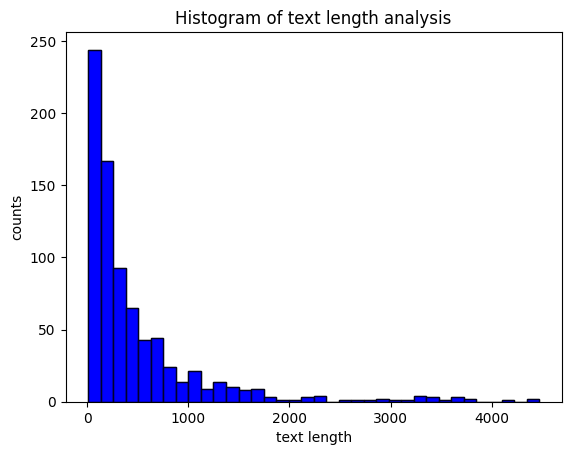

In [8]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib histogram
plt.hist(text_lengths, color = 'blue', edgecolor = 'black',
         bins = int(180/5))
# seaborn histogram
sns.distplot(text_lengths, hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of text length analysis')
plt.xlabel('text length')
plt.ylabel('counts')

In [9]:
sum([1 for i in range(len(text_lengths)) if text_lengths[i] >= MAX_LENGTH])

230

In [10]:
# ========================= load tokenizer START =========================
# 30,522 vocab is BERT's default vocab size, feel free to tweak
# vocab_size = 32010
# maximum sequence length, lowering will result to faster training (when increasing batch size)
max_length = 512 # 768
import transformers 
print(tokenizer_path)
# tokenizer = transformers.AutoTokenizer.from_pretrained(tokenizer_path)
tokenizer = transformers.AlbertTokenizer.from_pretrained(tokenizer_path)
print('tokenizer loaded ...')
print('vocab size: ', tokenizer.vocab_size)
vocab_size = tokenizer.vocab_size + 10
# ========================= load tokenizer END =========================



C:\Users\XinZhou\anaconda3\envs\dna\lib\site-packages\transformers\tokenization_utils_base.py:1678: FutureWarning: Calling AlbertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
loading file ..\..\cbert\pretrained\test_albert_NaCUT\tokenizer.model
Adding [CLS] to the vocabulary
Adding [SEP] to the vocabulary
Adding <pad> to the vocabulary
Adding [MASK] to the vocabulary
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


..\..\cbert\pretrained\test_albert_NaCUT\tokenizer.model
tokenizer loaded ...
vocab size:  32000


In [11]:
# text_ids = [tokenizer.encode(text, max_length=300, pad_to_max_length=True) for text in texts]
if not truncate_longer_samples:
    #tokenizer(examples["text"], return_special_tokens_mask=True)
    train_text_dict = [tokenizer(t, return_special_tokens_mask=True) for t in train_texts]
    valid_text_dict = [tokenizer(t, return_special_tokens_mask=True) for t in valid_texts]
    test_text_dict = [tokenizer(t, return_special_tokens_mask=True) for t in test_texts]
else:
    max_length = MAX_LENGTH
    train_text_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=max_length, return_special_tokens_mask=True) for t in train_texts]
    valid_text_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=max_length, return_special_tokens_mask=True) for t in valid_texts]
    test_text_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=max_length, return_special_tokens_mask=True) for t in test_texts]

In [12]:
train_text_ids = [text_id['input_ids'] for text_id in train_text_dict]
valid_text_ids = [text_id['input_ids'] for text_id in valid_text_dict]
test_text_ids = [text_id['input_ids'] for text_id in test_text_dict]
# text_ids[0]
train_att_masks = [text_id['attention_mask'] for text_id in train_text_dict]
valid_att_masks = [text_id['attention_mask'] for text_id in valid_text_dict]
test_att_masks = [text_id['attention_mask'] for text_id in test_text_dict]
# att_masks[0]

In [13]:
from sklearn.model_selection import train_test_split
train_x, train_m, train_y = train_text_ids, train_att_masks, train_labels
val_x, val_m, val_y = valid_text_ids, valid_att_masks, valid_labels
test_x, test_m, test_y = test_text_ids, test_att_masks, test_labels

In [14]:
import torch

train_x = torch.tensor(train_x)
test_x = torch.tensor(test_x)
val_x = torch.tensor(val_x)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)
val_y = torch.tensor(val_y)
train_m = torch.tensor(train_m)
test_m = torch.tensor(test_m)
val_m = torch.tensor(val_m)

print(train_x.shape)
print(test_x.shape)
print(val_x.shape)
print(train_y.shape)
print(test_y.shape)
print(val_y.shape)
print(train_m.shape)
print(test_m.shape)
print(val_m.shape)

torch.Size([800, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([800])
torch.Size([100])
torch.Size([100])
torch.Size([800, 512])
torch.Size([100, 512])
torch.Size([100, 512])


In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


print(train_x)
train_data = TensorDataset(train_x, train_m, train_y)
train_sampler = list(range(len(train_data)))


# train_sampler = train_sampler[:100]
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


val_data = TensorDataset(val_x, val_m, val_y)
val_sampler = list(range(len(val_data)))
# val_sampler = val_sampler[:100]
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)



# train_loader_extracted = torch.utils.data.DataLoader(train_extracted_data, batch_size=batch_size, shuffle=False,
#                                            sampler=train_sampler)


# valid_loader_extracted = torch.utils.data.DataLoader(valid_extracted_data, batch_size=batch_size, shuffle=False,
#                                            sampler=val_sampler)


tensor([[32000,    50,     3,  ..., 32002, 32002, 32002],
        [32000,    50,     3,  ...,     8,    32, 32001],
        [32000,    50,     3,  ...,   431,  1567, 32001],
        ...,
        [32000,    50,     3,  ...,  5152,   952, 32001],
        [32000,    50,     3,  ..., 32002, 32002, 32002],
        [32000,    50,     3,  ...,     8,    93, 32001]])


In [16]:
import torch.nn as nn
import torch
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import sys

class DotAttention(nn.Module):

    def __init__(self, hidden_size):
        super(DotAttention, self).__init__()

        self.hidden_size = hidden_size
        self.attn_vector = nn.Parameter(
            torch.Tensor(1, hidden_size), requires_grad=True)

        init.xavier_uniform(self.attn_vector.data)

    def get_mask(self):
        pass

    def forward(self, inputs, lengths=None):
        batch_size, max_len = inputs.size()[:2]

        '''
        print("INPUTS", inputs.size())
        print("ATTN", self.attn_vector  # (1, hidden_size)
                            .unsqueeze(0)  # (1, hidden_size, 1)
                            .transpose(2, 1)
                            .repeat(batch_size, 1, 1).size())'''
        # apply attention layer
        weights = torch.bmm(inputs,
                            self.attn_vector  # (1, hidden_size)
                            .unsqueeze(0)  # (1, 1, hidden_size)
                            .transpose(2, 1) # (1, hidden_size, 1)
                            .repeat(batch_size, 1, 1)) # (batch_size, hidden_size, 1))

        attn_energies = F.softmax(F.relu(weights.squeeze(axis=2)))

        # create mask based on the sentence lengths
        #idxes = torch.arange(0, max_len, out=torch.LongTensor(max_len)).unsqueeze(0).cuda()  # some day, you'll be able to directly do this on cuda
        #mask = Variable((idxes < lengths.data.unsqueeze(1)).float())

        # apply mask and renormalize attention scores (weights)
        #masked = attn_weights * mask
        _sums = attn_energies.sum(-1).unsqueeze(1).expand_as(attn_energies)  # sums per row
        attn_weights = attn_energies / _sums

        # print('attn_weights: ', attn_weights.shape)
        # apply attention weights

        weighted = torch.mul(inputs, attn_weights.unsqueeze(-1).expand_as(inputs))

        # print('weighted: ', weighted.shape)

        # get the final fixed vector representations of the sentences
        representations = weighted.sum(1).squeeze()
        
        if len(representations.shape) == 1:
            representations = representations.reshape(1, representations.shape[-1])
        # print('representations: ', representations.shape)

        return representations, attn_weights
    
from transformers import AutoModelForSequenceClassification
    
class BERTSourceBinaryClassification(nn.Module):
    def __init__(self,checkpoint, num_labels): 
        super(BERTSourceBinaryClassification,self).__init__() 
        self.num_labels = num_labels 
#         self.model = BertForMaskedLM.from_pretrained(checkpoint)
        #Load Model with given checkpoint and extract its body
        # self.model = AutoModelForSequenceClassification.from_pretrained(bert_model_path, num_labels=2)
        self.model  = AutoModel.from_pretrained(checkpoint, output_attentions=True, output_hidden_states=True)
        self.dropout = nn.Dropout(0.2)
        
        self.features = nn.Linear(56, 56)
        self.softmax = nn.Softmax()
        
        self.classifier = nn.Linear(768 * 4, num_labels) # load and initialize weights
        self.out = nn.Softmax()
        self.attn = DotAttention(hidden_size = 768)
    
    def forward_single(self, input_ids, attention_mask, labels, ex):
        outputs = self.model(input_ids, attention_mask=attention_mask)[0]
        # print(outputs)
        # outputs = outputs
        # hidden_states, pool_output, unknown, attention_weights
        pooler_output = outputs[:, 0, :]
        # max + last + attention START
        last =  outputs[:,-1] 
        attn, attention_weights = self.attn.forward(outputs)
        max_ , _ = torch.max(outputs, dim=1)
        concatenated = torch.cat([last, max_, attn, pooler_output], dim=1)
        # Add custom layers
        sequence_output = self.dropout(concatenated) #outputs[0]=last hidden state
        logits = self.classifier(sequence_output) # calculate losses
        #return logits, attention_weights
        #loss = None
        #if labels is not None:
            #loss_fct = nn.CrossEntropyLoss()
            #loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return logits, attention_weights
    
    def forward(self, input_ids=None, attention_mask=None, labels=None, ex=None, max_len=MAX_LENGTH, opt='mean'):
        #Extract outputs from the body
        final_logits = None
        final_attention_weights = None
        # pick the most suspicous one for final decision
        for i in range(0, max_len, 512):
            logits, attention_weights = self.forward_single(input_ids[:,i:i+512], attention_mask[:,i:i+512], labels, ex)
            if final_logits is None:
                final_logits = logits
                final_attention_weights = attention_weights
            else:
                final_logits = torch.cat([final_logits,  logits], dim=1)
                final_attention_weights = torch.cat([final_attention_weights,  attention_weights], dim=1)
            #loss, logits = output
        
        final_logits = final_logits.reshape(final_logits.shape[0], max_len//512, 2)
        
        if opt == 'mean':
            # mean 
            final_logits = torch.mean(final_logits, dim=(1))
        else:
            # max
            final_logits = torch.amax(final_logits, dim=(1))
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(final_logits.view(-1, self.num_labels), labels.view(-1))
            
        final_logits = self.softmax(final_logits)
        return (loss, final_logits), final_attention_weights


        #return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [17]:
print(bert_model_path)
model = BERTSourceBinaryClassification(checkpoint=bert_model_path, num_labels=2)

loading configuration file ..\..\cbert\pretrained\test_albert_NaCUT\checkpoint\config.json
Model config AlbertConfig {
  "_name_or_path": "..\\..\\cbert\\pretrained\\test_albert_NaCUT\\checkpoint",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 8192,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "output_attentions": true,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.21.2",
  "type_vocab_size": 2,
  "vocab_size": 32010
}

loading weights file ..\..\cbert\pretrained\test_

..\..\cbert\pretrained\test_albert_NaCUT\checkpoint


Some weights of the model checkpoint at ..\..\cbert\pretrained\test_albert_NaCUT\checkpoint were not used when initializing AlbertModel: ['predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at ..\..\cbert\pretrained\test_albert_NaCUT\checkpoint and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You sho

In [18]:

learning_rate = 1e-5
adam_epsilon = 1e-8

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.2},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

C:\Users\XinZhou\anaconda3\envs\dna\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
multi_gpu = torch.cuda.device_count() 
if multi_gpu > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
# model = nn.DataParallel(model)
model = model.cuda()

In [20]:

from transformers import get_linear_schedule_with_warmup


total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [21]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

import numpy as np
import random

seed_val = 111
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

import pickle
import os

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
# save model 

def save_model(model, train_losses, val_losses, out_dir_model):

    if not os.path.exists(out_dir_model):
        os.makedirs(out_dir_model)
    
    PATH = os.path.join(out_dir_model, 'BERTSourceBinaryClassification.pt')

    torch.save(model.state_dict(), PATH)

    with open(out_dir_model + '/train_losses.pkl', 'wb') as f:
        pickle.dump(train_losses, f)

    with open(out_dir_model + '/val_losses.pkl', 'wb') as f:
        pickle.dump(val_losses, f)
        
print('number of iterations: ', len(train_dataloader))

number of iterations:  100


In [ ]:
if not test_only:
    from tqdm import tqdm
    train_losses = []
    val_losses = []
    num_mb_train = len(train_dataloader)
    num_mb_val = len(val_dataloader)
    current_step = 0
    saved_steps = []
    if num_mb_val == 0:
        num_mb_val = 1

    # print('number of iterations: ', len(train_dataloader), len(train_loader_extracted))
    print('num_epochs: ', num_epochs)

    loss_fct = nn.CrossEntropyLoss()


    for n in range(num_epochs):
        train_loss = 0
        val_loss = 0
        start_time = time.time()

        #for k, (data1, data2) in enumerate(zip(train_dataloader, train_loader_extracted)):
        for k, (mb_x, mb_m, mb_y) in tqdm(enumerate(train_dataloader)):
            #mb_x, mb_m, mb_y = data1
            # 56 features
            #ex, ey, e_index = data2
            optimizer.zero_grad()
            model.train()

            mb_x = mb_x.cuda()
            mb_m = mb_m.cuda()
            mb_y = mb_y.cuda()
            #ex = ex.cuda()

            outputs, _, = model(mb_x, attention_mask=mb_m, labels=mb_y)
            #print(outputs[1])
            #mb_y = F.one_hot(mb_y)
            #print(outputs, mb_y)
            #loss = loss_fct(outputs.view(-1, 2), mb_y.view(-1))
            loss = outputs[0]

            if multi_gpu > 1:
                loss = loss.sum()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            current_step += 1
            train_loss += loss.data / num_mb_train

            if current_step % save_step_at == 0:
                saved_steps.append(current_step)
                out_dir_model = './{}/classification_model_{}'.format(out_dir, saved_steps[-1])
                print('saved as: ', out_dir_model)
                if len(saved_steps) > max_step_saves:
                    delete_dir = './{}/classification_model_{}'.format(out_dir, saved_steps[-(max_step_saves+1)])
                    os.system('rm -r {}'.format(delete_dir))
                save_model(model, train_losses, val_losses, out_dir_model)


        print ("\nTrain loss after itaration %i: %f" % (n+1, train_loss))
        train_losses.append(train_loss.cpu())

        with torch.no_grad():
            model.eval()

            for k, (mb_x, mb_m, mb_y) in enumerate(val_dataloader):
                mb_x = mb_x.cuda()
                mb_m = mb_m.cuda()
                mb_y = mb_y.cuda()

                outputs, _ = model(mb_x, attention_mask=mb_m, labels=mb_y)
                loss = outputs[0]
                if multi_gpu > 1:
                    loss = loss.sum()
                #loss = model_loss(outputs[1], mb_y)

                val_loss += loss.data / num_mb_val

            print ("Validation loss after itaration %i: %f" % (n+1, val_loss))
            # save the best
            print('val_losses: ', val_losses, float(val_loss.cpu()))
            if val_losses and float(val_loss.cpu()) <= min(val_losses):
                out_dir_model = './{}/classification_model_best'.format(out_dir)
                print('the best model updated')
                print('saved as: ', out_dir_model)
                save_model(model, train_losses, val_losses, out_dir_model)
            val_losses.append(float(val_loss.cpu()))

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Time: {epoch_mins}m {epoch_secs}s')
        if len(val_losses) > 3 and float(val_loss.cpu()) > max(val_losses[-4:-1]):
            break

num_epochs:  10


0it [00:00, ?it/s]C:\Users\XinZhou\AppData\Local\Temp\ipykernel_9620\1294117063.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_energies = F.softmax(F.relu(weights.squeeze(axis=2)))
C:\Users\XinZhou\AppData\Local\Temp\ipykernel_9620\1294117063.py:133: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  final_logits = self.softmax(final_logits)
100it [00:44,  2.23it/s]



Train loss after itaration 1: 0.700383
Validation loss after itaration 1: 0.675975
val_losses:  [] 0.6759752631187439
Time: 0m 46s


100it [00:45,  2.22it/s]



Train loss after itaration 2: 0.715992
Validation loss after itaration 2: 0.672396
val_losses:  [0.6759752631187439] 0.6723963022232056
the best model updated
saved as:  ./result_devign/classification_model_best
Time: 0m 47s


100it [00:42,  2.34it/s]



Train loss after itaration 3: 0.710995
Validation loss after itaration 3: 0.673746
val_losses:  [0.6759752631187439, 0.6723963022232056] 0.67374587059021
Time: 0m 44s


100it [00:38,  2.60it/s]



Train loss after itaration 4: 0.707245
Validation loss after itaration 4: 0.675893
val_losses:  [0.6759752631187439, 0.6723963022232056, 0.67374587059021] 0.6758934259414673
Time: 0m 40s


24it [00:09,  2.11it/s]

In [ ]:

# out_dir_model = '{}/classification_model_4000'.format(out_dir)

test_dir_model = '{}/classification_model_500'.format(out_dir)

PATH = os.path.join(test_dir_model, 'BERTSourceBinaryClassification.pt')
model.load_state_dict(torch.load(PATH))
model.eval()

with open(test_dir_model + '/train_losses.pkl', 'rb') as f:
    train_losses = pickle.load(f)
    
with open(test_dir_model + '/val_losses.pkl', 'rb') as f:
    val_losses = pickle.load(f)

print(val_losses)
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)

In [ ]:
from tqdm import tqdm
# test_data = test_data[:100]
test_data = TensorDataset(test_x, test_m)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


outputs = []
print('num of iterations: ', len(test_dataloader))
with torch.no_grad():
    for k, (mb_x, mb_m) in tqdm(enumerate(test_dataloader)):
        mb_x = mb_x.cuda()
        mb_m = mb_m.cuda()
#         output, _ = model(mb_x)
        output, attention_weights = model(mb_x, attention_mask=mb_m, max_len=MAX_LENGTH, opt='mean')
#         print(output)
#         print(attention_weights[4])
#         sys.exit(0)
        outputs.append(output[1].to('cpu'))
        
outputs = torch.cat(outputs)

In [ ]:
_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()
true_values = test_y.numpy()

test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)



In [ ]:
import itertools

# plot confusion matrix
# code borrowed from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cm_test = confusion_matrix(true_values, predicted_values)

np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset')
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset', normalize=True)